In [2]:
from igraph import *
import pandas as pd
import pickle
import time

In [3]:
#load Data
data = pd.read_csv('./xindai_2.csv')
data.shape,data.head()
#预处理
# data.dropna(subset=['id'],inplace=True)
data['overdue'].fillna(0,inplace=True)
data.drop_duplicates(inplace=True)
data.loc[data[data.overdue>0].index,'is_abnormal']=2
data['is_abnormal'] = data['is_abnormal'].astype(int)
data.head()

,id,id_1,id_2,id_3,is_abnormal,overdue
0,1.363927e+10,NaN,1.878687e+10,1.512023e+10,0,0.0
1,1.899508e+10,1.512198e+10,1.389532e+10,1.829570e+10,0,0.0
2,1.391930e+10,1.829326e+10,1.399326e+10,1.391971e+10,0,0.0
3,1.879515e+10,NaN,1.340952e+10,1.779551e+10,0,0.0
4,1.518083e+10,1.820851e+10,1.398416e+10,1.360850e+10,1,0.0


### 边类型
- id,id1,3 #父母
- id,id2,2 #亲属
- id,id3,1 #朋友，同事
- id1,id2,2 #亲属
- id3,id2,0.5  #可能认识
- id3,id1,0.5  #可能认识

In [4]:
#边类型1
e1= data.dropna(subset=['id_1'])[['id','id_1']]
e1['weight']=3
e1.rename(columns={'id':'src','id_1':'dsc'},inplace=True)
e2 = data.dropna(subset=['id_2'])[['id','id_2']]
e2['weight']=2
e2.rename(columns={'id':'src','id_2':'dsc'},inplace=True)
e3 = data.dropna(subset=['id_3'])[['id','id_3']]
e3['weight']=1
e3.rename(columns={'id':'src','id_3':'dsc'},inplace=True)
e3.head()

,src,dsc,weight
0,1.363927e+10,1.512023e+10,1
1,1.899508e+10,1.829570e+10,1
2,1.391930e+10,1.391971e+10,1
3,1.879515e+10,1.779551e+10,1
4,1.518083e+10,1.360850e+10,1


In [5]:
#边类型2
e4 = data.dropna(subset=['id_1','id_2'])[['id_1','id_2']]
e4['weight']=2
e4.rename(columns={'id_1':'src','id_2':'dsc'},inplace=True)
e5 = data.dropna(subset=['id_2','id_3'])[['id_2','id_3']]
e5['weight']=0.5
e5.rename(columns={'id_2':'src','id_3':'dsc'},inplace=True)
e6 = data.dropna(subset=['id_1','id_3'])[['id_1','id_3']]
e6['weight']=0.5
e6.rename(columns={'id_1':'src','id_3':'dsc'},inplace=True)
e6.head()

,src,dsc,weight
1,1.512198e+10,1.829570e+10,0.5
2,1.829326e+10,1.391971e+10,0.5
4,1.820851e+10,1.360850e+10,0.5
5,1.534690e+10,1.534690e+10,0.5
8,1.310760e+10,1.389752e+10,0.5


In [6]:
#合并边1
tmp1 = e1.append(e2)
tmp1 = tmp1.append(e3)
tmp1 = tmp1.groupby(by=['src','dsc'])['weight'].sum()
tmp1 = tmp1.reset_index()
tmp1[['src','dsc']] = tmp1[['src','dsc']].astype(int)
print 'edges cate 1:',tmp1.shape

#合并边2
tmp2 = e4.append(e5)
tmp2 = tmp2.append(e6)
tmp2 = tmp2.groupby(by=['src','dsc'])['weight'].sum()
tmp2 = tmp2.reset_index()
tmp2[['src','dsc']] = tmp2[['src','dsc']].astype(int)
print 'edges cate 2:',tmp2.shape

#合并所有边
tmp = tmp1.append(tmp2)
tmp = tmp.groupby(by=['src','dsc'])['weight'].sum()
tmp = tmp.reset_index()
print 'edges all:',tmp.shape
tmp.head()

edges cate 1: (225742, 3)
edges cate 2: (159604, 3)
edges all: (384327, 3)


,src,dsc,weight
0,-9223372036854775808,13408406838,0.5
1,-9223372036854775808,15884999749,0.5
2,-9223372036854775808,18285318123,0.5
3,-9223372036854775808,18982093661,0.5
4,1008,1359595856,0.5


### 节点编码 
适应igraph网络构建

In [7]:
#网络节点
id=data['id'].dropna().astype(int).tolist()
id_1= data['id_1'].dropna().astype(int).tolist()
id_2 =data['id_2'].dropna().astype(int).tolist()
id_3=data['id_3'].dropna().astype(int).tolist()
ids =set(id+id_1+id_2+id_3)
id_df=pd.DataFrame(data=list(ids),columns=['id'])
print id_df.head()
#重新编码
id_dict = id_df.reset_index().set_index('id').to_dict()['index']
id_dict

                    id
0 -9223372036854775808
1          15934685184
2          18285243051
3          13468521814
4          18748538886


{-9223372036854775808: 0,
 15934685184: 1,
 15808506539: 103947,
 18283582806: 51867,
 18748538886: 4,
 13708558337: 5,
 13778288649: 6,
 18886301721: 238703,
 13678149644: 8,
 18385731597: 9,
 13668188174: 10,
 15691856297: 263871,
 18744868881: 63,
 15228469266: 13,
 13096189971: 14,
 13789298708: 15,
 15870197781: 16,
 13848018967: 17,
 18213765145: 18,
 15129242971: 245811,
 15555624987: 20,
 13519698032: 243763,
 18291884061: 22,
 18284544031: 23,
 15593570573: 223811,
 15208546341: 24,
 15297151017: 26,
 13830717447: 27,
 18375245868: 28,
 18209570861: 29,
 18212192302: 30,
 13995343919: 31,
 13049528368: 32,
 15002501172: 35,
 18729664565: 36,
 18228445238: 37,
 13830455305: 156324,
 15950938168: 39,
 18981322809: 40,
 18380488764: 41,
 18981322818: 42,
 13468958788: 43,
 15291558582: 44,
 13453230150: 45,
 18608554055: 46,
 13988003912: 47,
 15198060556: 48,
 13931380810: 49,
 13809745995: 50,
 18295291917: 156326,
 13909045306: 52,
 18093703253: 54,
 18988138583: 55,
 15204876

In [8]:
#添加节点标签
id_label = data.groupby(by=['id'])['is_abnormal'].apply(lambda a:list(a)[-1])
id_label = id_df.merge(id_label.reset_index(),on='id',how='left')
id_label.drop_duplicates(inplace=True)
del id_df
id_label['is_abnormal'].fillna(3,inplace=True) #未知状态用户
id_label.head()

,id,is_abnormal
0,-9223372036854775808,3.0
1,15934685184,3.0
2,18285243051,3.0
3,13468521814,0.0
4,18748538886,3.0


In [23]:
#各节点在贷款单中出现的次数
usr_time = pd.read_csv('./usr_all_time.csv',sep='\001')
id_label = id_label.merge(usr_time,on='id',how='left')
id_label

,id,is_abnormal,times_x,role_x,times_y,role_y
0,-9223372036854775808,3.0,4,"[2, 2, 2, 2]",4,"[2, 2, 2, 2]"
1,15934685184,3.0,1,[2],1,[2]
2,18285243051,3.0,1,[3],1,[3]
3,13468521814,0.0,1,[0],1,[0]
4,18748538886,3.0,1,[2],1,[2]
5,13708558337,3.0,1,[2],1,[2]
6,13778288649,1.0,1,[0],1,[0]
7,15894926679,3.0,1,[1],1,[1]
8,13678149644,1.0,1,[0],1,[0]
9,18385731597,1.0,1,[0],1,[0]


## 构建网络

In [11]:
def gen_graph(edgeList):    
    #添加节点
    g= Graph(directed=True)
    g.add_vertices(id_label.shape[0])
    g.vs['name']=id_label['id'].tolist()  #将节点id与节点index映射
    g.vs['label']=id_label['is_abnormal'].astype(int).tolist() #点标签属性
    g.vs['times']=id_label['times'].tolist()
    g.vs['roles']=id_label['role'].tolist()
    print 'vertex count:',g.vcount()
    #添加边
    edges=zip(edgeList['src'],edgeList['dsc'])
    g.add_edges(edges)
    g.es['weight'] = edgeList['weight'].tolist() #边属性
    print 'edge count:',g.ecount()
    return g

In [12]:
#网络1
tmp1['src']=tmp1['src'].map(id_dict)
tmp1['dsc']=tmp1['dsc'].map(id_dict)
g1 = gen_graph(tmp1)
tmp1.head()

vertex count: 314314
edge count: 225742


,src,dsc,weight
0,166919,45970,1
1,226327,262021,1
2,138821,240087,1
3,138821,243539,2
4,206446,123164,2


In [13]:
#网络2
tmp['src']=tmp['src'].map(id_dict)
tmp['dsc']=tmp['dsc'].map(id_dict)
g2 = gen_graph(tmp)
tmp.head()

vertex count: 314314
edge count: 384327


,src,dsc,weight
0,0,158326,0.5
1,0,123288,0.5
2,0,148928,0.5
3,0,166483,0.5
4,584,267965,0.5


### 子图提取

In [14]:
#行为次数大于3的节点
ab_usr = pd.read_csv('./usr_all_ab.csv',sep='\001')
ab_usr['index'] = ab_usr['id'].map(id_dict)
ab_usr

# sub_ab = g1.subgraph(ab_usr['index'].tolist())
sub_ab = g2.subgraph(ab_usr['index'].tolist())
sub_ab.summary()

,id,times,role,index
0,-9223372036854775808,4,"[2, 2, 2, 2]",0
1,1008,178,"[3, 2, 1]",584
2,1009,9,"[2, 1]",17991
3,1016,4,"[3, 2]",3647
4,13000001008,15,"[0, 1]",166919
5,13007879628,3,"[0, 3, 1]",175399
6,13007897663,5,"[0, 1]",186293
7,13049519499,3,[2],309008
8,13049564299,3,"[3, 2, 1]",128346
9,13049582466,3,"[0, 3, 1]",193858


In [15]:
visual_style =lay(sub_ab)
plot(sub_ab,'./picture/sub_ab.png', **visual_style)    

NameError: name 'lay' is not defined

In [16]:
# sub_ab = sub_ab.simplify(combine_edges=sum)
f=open('./edge_file/sub_ab_g2.dot','w')
sub_ab.write_dot(f)
f.close()   

In [17]:
#申请人子网络
applicates = id_label[id_label.is_abnormal.isin([0.0,1.0,2.0])]
applicates = applicates[applicates.times>1]
applicates['index']  =applicates['id'].map(id_dict)
# sub_ap = g1.subgraph(applicates['index'].tolist())
sub_ap = g2.subgraph(applicates['index'].tolist())
sub_ap.summary()

'IGRAPH DNW- 6804 4222 -- \n+ attr: label (v), name (v), roles (v), times (v), weight (e)'

In [18]:
f=open('./edge_file/sub_applicate_g2.dot','w')
sub_ap.write_dot(f)
f.close()

### 社团划分

In [19]:
#社团大小-社团个数统计
def com_size(coms):
    print 'community number:',len(coms)
    com_size=[len(com) for com in coms]    
    sf = pd.Series(com_size)
    print sf.value_counts()

In [20]:
#社团划分
def com_detection(g,fun='multilevel'):
    start = time.time()
    if fun=='multilevel':
        communities = g.community_multilevel(weights='weight')
    elif fun=='fastgreedy':
        ug= g.simplify(combine_edges=sum) #合并相同节点的多条边和自环
        fg = g.community_fastgreedy(weights='weight')
        communities = fg.as_clustering()
    elif fun=='walktrap':
        wt = g.community_walktrap(weights='weight')
        communities = wt.as_clustering()
    else:
        communities = g.community_label_propagation(weights='weight')
    print 'cost time(s):',(time.time()-start)
    return communities

In [115]:
#multilevel
communities = com_detection(g1,fun='walktrap')
com_size(communities) 

cost time(s): 999.817740917
community number: 91859
3      58893
4      24663
2       2730
5       2727
6       1460
7        770
8        192
9        152
1         90
10        65
11        43
13        20
12        16
15        11
14         9
16         4
19         4
18         3
17         2
21         2
546        1
22         1
40         1
dtype: int64


In [22]:
communities = com_detection(g2,fun='walktrap')
com_size(communities) 

cost time(s): 1082.17193079
community number: 91856
3      58893
4      24663
2       2733
5       2727
6       1460
7        770
8        192
9        152
1         84
10        65
11        43
13        20
12        16
15        11
14         9
16         4
19         4
18         3
17         2
21         2
546        1
22         1
40         1
dtype: int64


In [74]:
#label_propagation
communities_lp =com_detection(g1,fun='label_propagation')
com_size(communities_lp)

cost time(s): 2.29591798782
community number: 96904
3      62988
4      25795
2       6437
5        910
6        546
7        110
1         93
8         18
9          5
406        1
12         1
dtype: int64


In [ ]:
communities_lp =com_detection(g2,fun='label_propagation')
com_size(communities_lp)

### 结果存储与可视化

In [51]:
def save_graph(coms,g,graph_fName):
    #默认保存大小大于12的社团
    communities = [com for com in coms if len(com)==18]
    print 'community number which size bigger than 12:',len(communities)
    nodes = []
    for com in communities:
        nodes = nodes+com
    print 'nodes number:',len(nodes)

    #大于12的社团子图
    sub_g=g.subgraph(nodes)
    print sub_g.vcount(),sub_g.ecount()
    #save
    f=open('./edge_file/%s.dot' %graph_fName,'w')
    sub_g.write_dot(f)
    f.close()    

In [30]:
def save_sub(coms,g,graph_fName,com_size):
    #最大社团
    com_max = [com for com in coms if len(com)==com_size]
    sub_max = g.subgraph(com_max[0])
    print sub_max.vcount(),sub_max.ecount()
    #save
    f = open('./edge_file/%s.dot'%graph_fName,'w')
    sub_max.write_dot(f)
    f.close()
    #display
    visual_style = lay(sub_max)
    plot(sub_max,'./picture/%s.png'%graph_fName, **visual_style)    

In [35]:
#可视化布局
def lay(graph):
    visual_style = {}
    size_map={1:30,2:30,0:20,3:20}
    visual_style["vertex_size"] = [size_map[l] for l in graph.vs['label']]
    color_map = {0:'Gray',1:'red',2:'pink',3:'blue'}
    visual_style["vertex_color"] = [color_map[l] for l in graph.vs['label']]
    visual_style["vertex_label"] = graph.vs["label"]
    visual_style["edge_width"] = [2 * w for w in graph.es["weight"]]
    visual_style["layout"] = graph.layout('kk')  #kk
    visual_style["bbox"] = (1000, 1000)
    return visual_style
# visual_style["margin"] = 20

In [52]:
#标签传播社团划分结果
save_graph(communities,g1,'sub_graph_18')
# save_sub(communities,g1,'sub_max_546',546)
# save_sub(communities,g1,'sub_size_22',22)

# save_graph(communities,g2,'sub_graph_11_g2')
# save_sub(communities,g2,'sub_max_546_g2',546)
# save_sub(communities,g2,'sub_size_40_g2',40)

community number which size bigger than 12: 3
nodes number: 54
54 51


### 其他操作

In [65]:
#大小大于12的社团
communities = [com for com in communities if len(com)>12]
print 'community number which size bigger than 12:',len(communities)
nodes = []
for com in communities:
    nodes = nodes+com
print 'nodes number:',len(nodes)

#大于12的社团子图
sub_g=g2.subgraph(nodes)
print sub_g.vcount(),sub_g.ecount()
#save
f=open('./edge_file/sub_graph_12_g2.dot','w')
sub_g.write_dot(f)
f.close()

community number which size bigger than 12: 58
nodes number: 1429
1429 2548


546 554


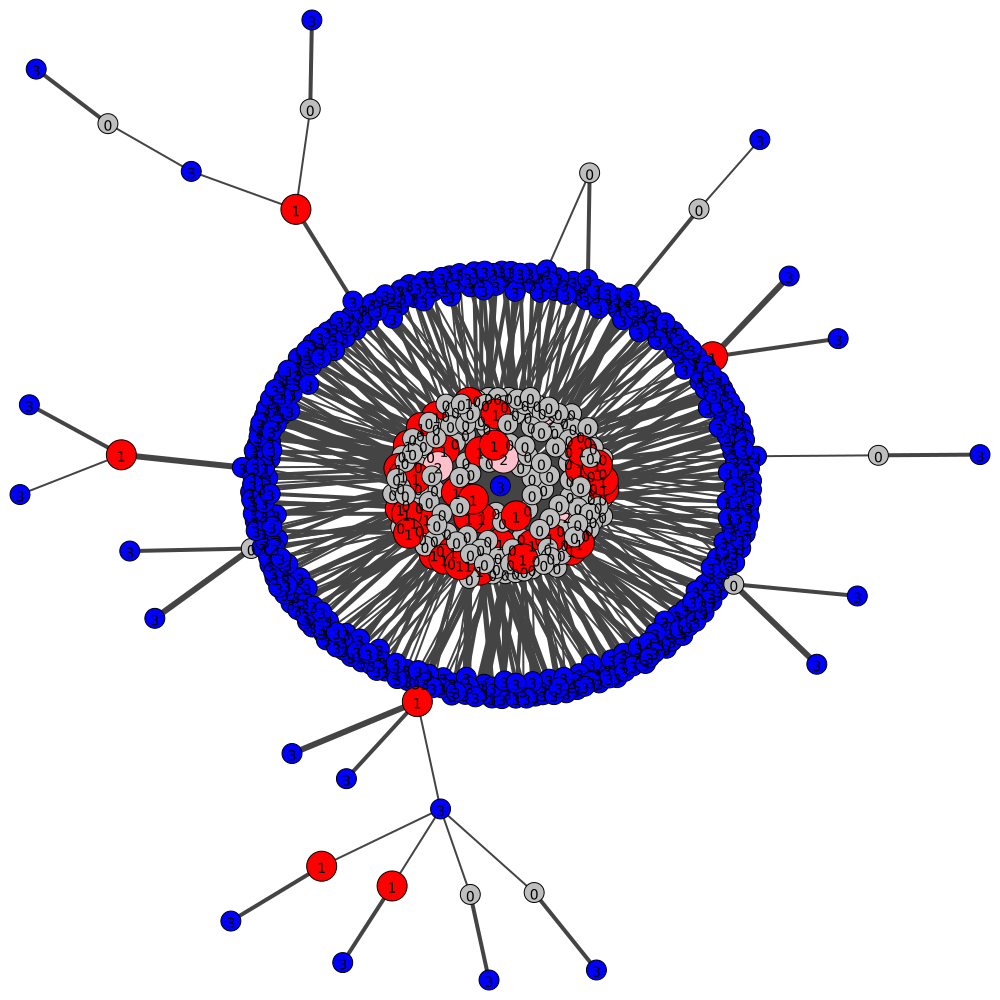

In [93]:
#最大社团
com_max = [com for com in communities if len(com)==546]
sub_max = g1.subgraph(com_max[0])
print sub_max.vcount(),sub_max.ecount()
#save
f = open('./edge_file/sub_max.dot','w')
sub_max.write_dot(f)
f.close()
#display
visual_style = lay(sub_max)
plot(sub_max,'./picture/sub_max_546.eps', **visual_style)

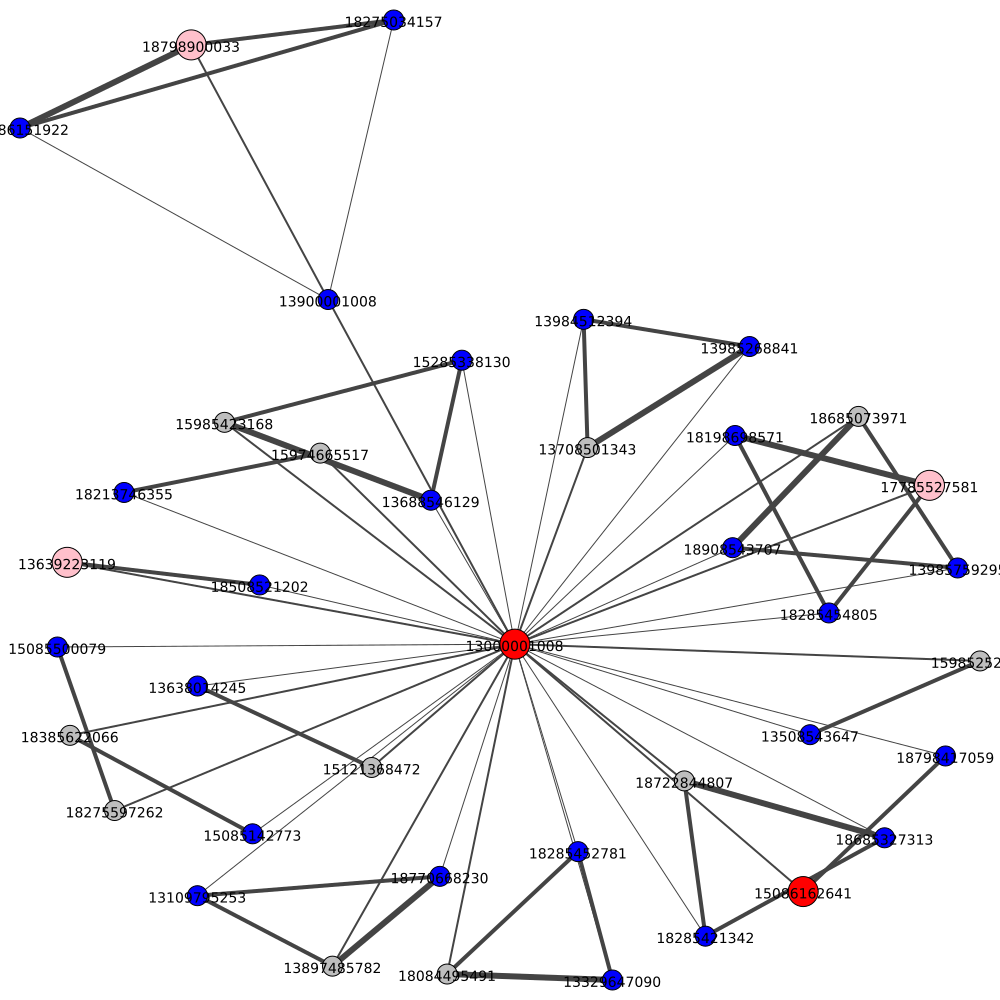

In [69]:
com_40 = [com for com in communities if len(com)==40]
sub_40 = g1.subgraph(com_40[0])
sub_40.vcount(),sub_40.ecount()
#save
f = open('./edge_file/sub_40.dot','w')
sub_40.write_dot(f)
f.close()
#display
vs_40 = lay(sub_40)
plot(sub_40,'./picture/sub_40.pdf',**vs_40)

In [113]:
t = data[data.id==13000001008].append(data[data.id_3==13000001008])
t.astype(str)

,id,id_1,id_2,id_3,is_abnormal,overdue
51880,13000001008.0,nan,nan,13900001008.0,1,0.0
11433,15121368472.0,nan,13638014245.0,13000001008.0,0,0.0
11477,15086162641.0,nan,18798417059.0,13000001008.0,1,0.0
16591,15974665517.0,nan,18213746355.0,13000001008.0,0,0.0
21219,13639223119.0,nan,18508521202.0,13000001008.0,2,1.0
21439,18722844807.0,18685327313.0,18285421342.0,13000001008.0,0,0.0
37428,15985252019.0,nan,13508543647.0,13000001008.0,0,0.0
40463,18084495491.0,13329647090.0,18285452781.0,13000001008.0,0,0.0
42748,17785527581.0,18198698571.0,18285454805.0,13000001008.0,2,1.0
43428,18275597262.0,nan,15085500079.0,13000001008.0,0,0.0


### 社团划分
#### 1. fastgreedy  速度较慢

In [85]:
#社团划分
ug= g.simplify(combine_edges=sum)
strat = time.time()
fg = g.community_fastgreedy(weights='weight')
print 'cost time(s):',(time.time()-start)
print 'communities number',len(fg.as_clustering())
#社团划分结果缓存
f_com = open('communities_fg.txt','wb')
pickle.dump(fg.as_clustering(),f_com)
f_com.close()
com_size(fg.as_clustering())

KeyboardInterrupt: 

#### 2.community_multilevel  速度最快(1.35秒)

In [96]:
start = time.time()
cm = g.community_multilevel(weights='weight')
print 'cost time(s):',(time.time()-start)
com_size(cm)

cost time(s): 1.35096788406


#### 3.community_walktrap 948秒

In [97]:
start = time.time()
wt = g.community_walktrap(weights='weight')
print 'cost time(s):',(time.time()-start)
communities = wt.as_clustering()

cost time(s): 948.063256025


#### 4.label_propagation 较快2秒

In [101]:
start = time.time()
lp = g.community_label_propagation(weights='weight')
print 'cost time(s):',(time.time()-start)
com_size(lp)

cost time(s): 2.15737009048
3      62978
4      25799
2       6427
5        915
6        549
7        109
1         92
8         18
9          6
396        1
12         1
dtype: int64
